### 🖋️ Author Guess

In this notebook, we will build a **classification model** for the **Spooky Author Identification** task.  
The goal is to predict the author of a given text snippet based on their writing style.  

The dataset used for this task is available on [Kaggle](https://www.kaggle.com/competitions/spooky-author-identification/).

> Dataset link: https://www.kaggle.com/competitions/spooky-author-identification/

---

### ⚙️ Installing Helper Packages

In the following code cell, we will install the packages `helperfns`, `kaggle`, and `pigmenta`.  
These libraries provide useful utilities for machine learning workflows, including data preprocessing, visualization, and experiment management.

**References:**

1. [helperfns on PyPI](https://pypi.org/project/helperfns/)  
2. [pigmenta on PyPI](https://pypi.org/project/pigmenta/)


In [1]:
!pip install helperfns kaggle pigmenta -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 186.5/186.5 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.3/650.3 kB 33.0 MB/s eta 0:00:00


### 📦 Imports

In the following code cell, we will import all the necessary packages that will be used throughout this notebook.  
These include libraries for data handling, visualization, and model development.


In [2]:

import torch
import random
import warnings
import seaborn as sns
import os
import json
import re
import time

from pyspark.sql import SparkSession
from pyspark.sql.functions import lower, regexp_replace, length, avg, explode, col, size
from pyspark.ml.feature import Tokenizer
from pyspark.sql import functions as Fn

from collections import Counter, defaultdict
from helperfns.tables import tabulate_data
from pigmenta import PALETTES
from helperfns.visualization import plot_wordcloud, plot_classification_report, plot_complicated_confusion_matrix
from helperfns.utils import hms_string
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score, mutual_info_score, adjusted_rand_score
from sklearn.manifold import TSNE
from sklearn.cluster import SpectralClustering
from torch import nn
from sklearn.utils import resample
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from google.colab import drive

warnings.filterwarnings('ignore')

print("torch: ", torch.__version__)
print("numpy: ", np.__version__)
print("pandas: ", pd.__version__)

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


torch:  2.8.0+cu126
numpy:  2.0.2
pandas:  2.2.2


### Mounting Google Drive
In the following code cell we are going to mount the google drive where our pretrained word vectors will be loaded from.

In [3]:
drive.mount('/content/MyDrive')

Mounted at /content/MyDrive


### 🎲 Setting Seeds

In the following code cell, we will set a fixed seed value for all random operations to ensure **reproducibility** of the results.  
This helps guarantee that the model produces consistent outputs every time the notebook is run.


In [4]:
SEED = 23
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deteministic = True

### 🖥️ Device

In the following code cell, we will check for the availability of a **GPU** device and use it if possible.  
Utilizing a GPU can significantly accelerate model training and computations `(Khairy et al., 2020)`.


### Refs:

1. Khairy, M., Shen, Z., Aamodt, T.M. and Rogers, T.G., 2020, May. Accel-sim: An extensible simulation framework for validated gpu modeling. In 2020 ACM/IEEE 47th Annual International Symposium on Computer Architecture (ISCA) (pp. 473-486). IEEE.

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### 📂 Dataset

Next, we will read our data from text files into a **Pandas DataFrame** using the `read_csv` method.  
We will load only the `train.csv` file, as it contains the text samples along with their corresponding **authors** and **labels**.


### 📝 Dataset Description

The dataset for this competition contains text excerpts from works of fiction written by **public-domain spooky authors**:

- Edgar Allan Poe  
- H.P. Lovecraft  
- Mary Shelley  

The text was prepared by **chunking larger works into individual sentences** using CoreNLP's MaxEnt sentence tokenizer. As a result, you may occasionally notice non-standard or partial sentences.  

**Objective:** Accurately identify the author of each sentence in the test set based on writing style.


### 🔍 Data Analysis Using Spark

**Objective**

The goal is to analyze the text data to understand **stylistic differences among authors**, without building a predictive model at this stage.  
The analysis may include:

- Number of texts per author  
- Average text length per author  
- Most frequent words used by each author  
- Distribution of sentence or word lengths  
- Common stylistic markers (e.g., punctuation usage, stop-word ratios)


We will start by **creating a Spark session** to handle the data efficiently and perform distributed analysis.


In [7]:
spark = SparkSession.builder.appName("AuthorStyleAnalysis").getOrCreate()
spark

Next we load the dataset in a csv file.

In [8]:
df = spark.read.csv("train.csv", header=True, inferSchema=True)
df.printSchema()
df.show(2)

root
 |-- id: string (nullable = true)
 |-- text: string (nullable = true)
 |-- author: string (nullable = true)

+-------+--------------------+------+
|     id|                text|author|
+-------+--------------------+------+
|id26305|This process, how...|   EAP|
|id17569|It never once occ...|   HPL|
+-------+--------------------+------+
only showing top 2 rows



Next, we will perform **basic cleaning** on the dataset to prepare the text for analysis.  
This may include tasks such as removing special characters, converting text to lowercase, and other standard preprocessing steps.

In [9]:
df = df.withColumn("clean_text", lower(regexp_replace("text", "[^a-zA-Z\\s]", "")))

### 📊 Exploratory Data Analysis (EDA)

**a) Number of Records per Author**

In this step, we will analyze the **number of text samples contributed by each author** to understand the dataset distribution and identify any class imbalances.


In [10]:
df.groupBy("author").count().orderBy("count", ascending=False).show(3)


+------+-----+
|author|count|
+------+-----+
|   EAP| 7044|
|   MWS| 5552|
|   HPL| 5451|
+------+-----+
only showing top 3 rows



**b) Average Text Length per Author**

We will calculate the **average length of text samples** for each author.  
This helps us understand differences in writing style, such as whether some authors tend to write longer or shorter sentences.


In [11]:
df = df.withColumn("text_length", length("clean_text"))
df.groupBy("author").agg(avg("text_length").alias("avg_length")).orderBy("avg_length", ascending=False).show(10)

+--------------------+----------+
|              author|avg_length|
+--------------------+----------+
| yet satisfied me...|    3669.0|
|          nor device|     830.0|
|"" c.; and Mr. He...|     651.0|
| in a supplicatin...|     644.0|
| in the minds of ...|     624.0|
|"" she said: ""I ...|     591.0|
|    clew up all sail|     513.0|
| and strengthen w...|     483.0|
|        "" by Mackey|     446.0|
| and rendering me...|     442.0|
+--------------------+----------+
only showing top 10 rows



**c) Most Common Words Overall**

In this step, we will identify the **most frequently occurring words** across the entire dataset.  
This analysis provides insights into common vocabulary and recurring themes in the texts.


In [12]:
tokenizer = Tokenizer(inputCol="clean_text", outputCol="words")
df = tokenizer.transform(df)

**d) Flatten and Count Words**

We will **explode the tokenized words** from all texts and count their occurrences.  
This allows us to determine the frequency of each word across the dataset for further analysis.


In [13]:
word_counts = df.select(explode(col("words")).alias("word")) \
                .groupBy("word").count().orderBy("count", ascending=False)
word_counts.show(10)

+----+-----+
|word|count|
+----+-----+
| the|33642|
|  of|19828|
| and|16913|
|  to|12021|
|   a|10059|
|   i| 9927|
|  in| 8888|
| was| 6442|
|that| 6005|
|  my| 5012|
+----+-----+
only showing top 10 rows



**e) Most Common Words per Author**

In this step, we will analyze the **most frequently used words by each individual author**.  
This helps highlight distinctive vocabulary and stylistic patterns unique to each writer.


In [14]:
words_by_author = df.select("author", explode(col("words")).alias("word")) \
                    .groupBy("author", "word").count()
words_by_author.orderBy("author", "count", ascending=False).show(5)


+------+----+-----+
|author|word|count|
+------+----+-----+
|   MWS| the| 8828|
|   MWS|  of| 5634|
|   MWS| and| 5554|
|   MWS|  to| 4325|
|   MWS|   i| 3695|
+------+----+-----+
only showing top 5 rows



**f) Average Number of Words per Text per Author**

We will calculate the **average word count** for each text per author.  
This metric provides insight into the typical length of sentences or excerpts used by different authors.


In [15]:
df = df.withColumn("word_count", size(col("words")))
df.groupBy("author").agg(avg("word_count").alias("avg_words")).orderBy("avg_words", ascending=False).show(10)


+--------------------+---------+
|              author|avg_words|
+--------------------+---------+
| yet satisfied me...|    671.0|
|          nor device|    149.0|
| in a supplicatin...|    119.0|
|"" c.; and Mr. He...|    116.0|
|"" she said: ""I ...|    113.0|
| in the minds of ...|    106.0|
|    clew up all sail|     93.0|
| and strengthen w...|     82.0|
| I placed her on ...|     82.0|
|        "" by Mackey|     81.0|
+--------------------+---------+
only showing top 10 rows



In the following code cell we are going to check the largest sentence in the dataset.

In [16]:

max_length_row = df.orderBy(col("word_count").desc()).limit(1)
result = max_length_row.collect()[0]
print(f"The largest sentence has {result['word_count']} words.")
print(f"Sentence: {result['clean_text']}")

The largest sentence has 671 words.
Sentence: diotima approached the fountain seated herself on a mossy mound near it and her disciples placed themselves on the grass near her without noticing me who sat close under her she continued her discourse addressing as it happened one or other of her listeners but before i attempt to repeat her words i will describe the chief of these whom she appeared to wish principally to impress one was a woman of about years of age in the full enjoyment of the most exquisite beauty her golden hair floated in ringlets on her shoulders her hazle eyes were shaded by heavy lids and her mouth the lips apart seemed to breathe sensibility but she appeared thoughtful unhappy her cheek was pale she seemed as if accustomed to suffer and as if the lessons she now heard were the only words of wisdom to which she had ever listened the youth beside her had a far different aspect his form was emaciated nearly to a shadow his features were handsome but thin worn his eyes

### Stylometric Indicators

In addition to basic statistics, we can compute **style-related metrics** to capture more nuanced differences in writing styles:

- **Vocabulary Richness:** Ratio of unique words to total words.  
- **Stop-word Ratio:** Proportion of stop-words compared to content words.  
- **Average Sentence Length:** Indicator of writing complexity and sentence structure.

**Example (Vocabulary Richness):**  
We can calculate the ratio of unique words to total words for each author to compare their lexical diversity.


In [17]:
unique_counts = df.select("author", explode("words").alias("word")) \
    .groupBy("author") \
    .agg(Fn.countDistinct("word").alias("unique_words"), Fn.count("word").alias("total_words"))

vocab_richness = unique_counts.withColumn("vocab_ratio", Fn.col("unique_words") / Fn.col("total_words"))
vocab_richness.orderBy("vocab_ratio", ascending=False).show(10)

+--------------------+------------+-----------+-----------+
|              author|unique_words|total_words|vocab_ratio|
+--------------------+------------+-----------+-----------+
| and we continued...|           5|          5|        1.0|
| who gave me this...|           5|          5|        1.0|
|  thet Afriky book?"|           1|          1|        1.0|
| who art called o...|           8|          8|        1.0|
| and the supposit...|           8|          8|        1.0|
| turning abruptly...|           4|          4|        1.0|
|      and very happy|           2|          2|        1.0|
| ""It gave me the...|          22|         22|        1.0|
| "" continued Bedloe|           2|          2|        1.0|
| astonished not m...|           4|          4|        1.0|
+--------------------+------------+-----------+-----------+
only showing top 10 rows



In the next code cell, we will **convert our Spark DataFrame to a Pandas DataFrame**.  
This allows us to leverage Pandas functionality for further analysis and visualization.


In [18]:
dataframe = df.toPandas()
dataframe.head(2)

,id,text,author,clean_text,text_length,words,word_count
0,id26305,"This process, however, afforded me no means of...",EAP,this process however afforded me no means of a...,224,"[this, process, however, afforded, me, no, mea...",41
1,id17569,It never once occurred to me that the fumbling...,HPL,it never once occurred to me that the fumbling...,70,"[it, never, once, occurred, to, me, that, the,...",14


In the next code cell, we will **remove any null or missing values** from the DataFrame to ensure clean and consistent data for analysis.

In [19]:
if sum(dataframe.isna().any()):
  dataframe.dropna(inplace=True)
  dataframe.reset_index(drop=True, inplace=True)
dataframe.isna().any()

,0
id,False
text,False
author,False
clean_text,False
text_length,False
words,False
word_count,False


In the following code cell, we will **check the size of the dataset** after removing null values to confirm the number of remaining records.


In [235]:
print(f"The dataset size is: {len(dataframe):,}")

The dataset size is: 19,579


In [236]:
dataframe2 = pd.read_csv("train.csv")
if sum(dataframe2.isna().any()):
  dataframe2.dropna(inplace=True)
  dataframe2.reset_index(drop=True, inplace=True)
dataframe2.isna().any()
dataframe2.head(2)

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL


In the following code cell, we are going to define a threshold value and filter out all text entries that contain fewer words than this threshold.

In [237]:
threshold = 23
dataframe2 = dataframe2[dataframe2['text'].apply(lambda x: len(str(x).split()) >= threshold)]
dataframe2.head(2)

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP


Next, we are going to inspect a few examples from the dataset after removing all rows containing text with fewer words than the defined threshold.


In [238]:
print(f"The dataset size is: {len(dataframe2):,}")

The dataset size is: 10,183


In this section, we will **visualize the dataset** using charts.  
First, we will examine the **distribution of authors** with a bar chart to understand how the text samples are distributed across different authors.


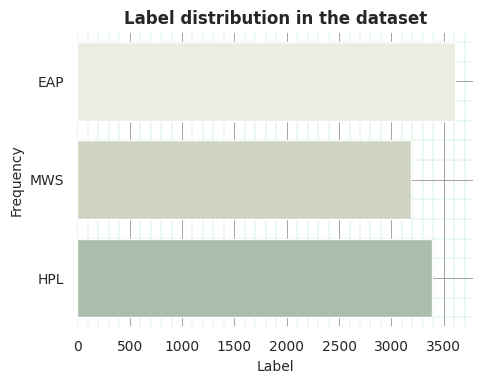

In [239]:
sns.set(font_scale=.8)
sns.set_style("white", rc={"axes.spines.right": True, "axes.spines.top": True})
sns.set(rc={"axes.facecolor": "#FFFFFF", "figure.facecolor": "#FFFFFF"})

plt.figure(figsize=(5, 4))
sns.countplot(data=dataframe2, y="author", palette=PALETTES.food,
              legend=False,  fill=True)
plt.xlabel("Label", fontsize=10)
plt.ylabel("Frequency", fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.title(f"Label distribution in the dataset", fontsize=12, weight="bold")
plt.minorticks_on()
plt.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
plt.grid(which='minor', color='#7ED4AD', linestyle='--', linewidth=0.3)
plt.tight_layout()
plt.show()

### ⚖️ Handling Class Imbalance

The dataset is **not balanced**, meaning some author classes have significantly more examples than others.  
To ensure that **accuracy** remains a reliable performance metric, we will **downsample the majority classes** so that each author class has approximately the same number of samples as the minority class.  

This approach helps prevent the model from becoming biased toward the majority classes and allows for a more fair evaluation of model performance.


In [240]:
new_dataframe = dataframe2.copy()

min_class_count = new_dataframe['author'].value_counts().min()
downsampled_list = []
for author in new_dataframe['author'].unique():
    class_df = new_dataframe[new_dataframe['author'] == author]
    downsampled_class_df = resample(
        class_df,
        replace=False,
        n_samples=min_class_count,
        random_state=SEED
    )
    downsampled_list.append(downsampled_class_df)
balanced_df = pd.concat(downsampled_list).reset_index(drop=True)

### 🍰 Visualizing the Balanced Dataset

In the following code cell, we are going to **visualize the distribution** of the balanced dataset using a **pie chart**.  
This visualization helps us confirm that all author classes now have approximately equal representation after the downsampling process.


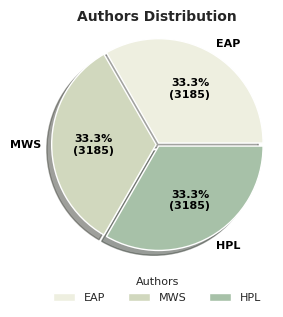

In [241]:
samples = dict(balanced_df.author.value_counts())

def fmt(x, total):
    return '{:.1f}%\n({:.0f})'.format(x, total*x/100)

plt.figure(figsize=(3, 3))
plt.pie(
    list(samples.values()),
    labels=list(samples.keys()),
    pctdistance=0.6, shadow=True,
    autopct=lambda x: fmt(x, sum(samples.values())),
    textprops={'color': 'black', 'fontsize': 8, 'weight': 'bold'},
    radius=.6, colors=PALETTES.food,
    explode=[.01 for _ in range(len(samples))]
)
plt.axis('equal')
plt.title("Authors Distribution", fontsize=10, weight="bold")
plt.legend(
    labels=list(samples.keys()),
    fontsize=8, loc="upper center",
    bbox_to_anchor=(0.5, -0.03),
    title="Authors", ncol=3, frameon=False, title_fontsize=8
)
plt.show()

In the following code cell, we will **split the dataset into training, validation and testing sets**.  
The testing set will also be used for **model evaluation** during training and **validation** to assess performance.


In [242]:
train, test = train_test_split(balanced_df, test_size=0.2, random_state=SEED)
train, valid = train_test_split(train, test_size=0.2, random_state=SEED)
train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)
valid.reset_index(drop=True, inplace=True)

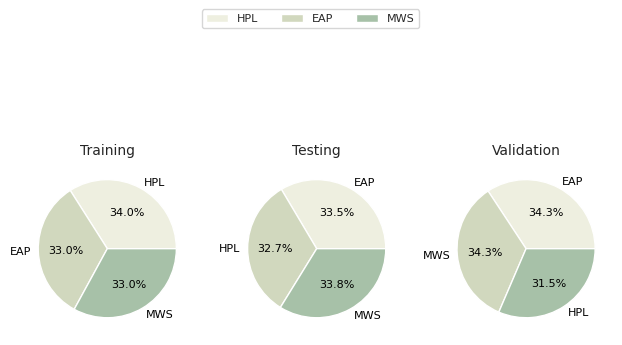

In [243]:
train_dist_label	= {i:0 for i in train.author.unique()}
for val in train.author:
  train_dist_label[val] += 1

test_dist_label	= {i:0 for i in test.author.unique()}
for val in test.author:
  test_dist_label[val] += 1

valid_dist_label	= {i:0 for i in valid.author.unique()}
for val in valid.author:
  valid_dist_label[val] += 1

fig, axes = plt.subplots(1, 3)

axes[0].pie(train_dist_label.values(), labels=train_dist_label.keys(), autopct='%1.1f%%',
            textprops={'color': 'black', 'fontsize':8}, radius=1,
            colors= PALETTES.food
            )
axes[0].set_title("Training", fontsize=10)

axes[1].pie(test_dist_label.values(), labels=test_dist_label.keys(), autopct='%1.1f%%',
            textprops={'color': 'black', 'fontsize':8}, radius=1,
            colors= PALETTES.food
            )
axes[1].set_title("Testing", fontsize=10)

axes[2].pie(valid_dist_label.values(), labels=valid_dist_label.keys(), autopct='%1.1f%%',
            textprops={'color': 'black', 'fontsize':8}, radius=1,
            colors= PALETTES.food)
axes[2].set_title("Validation", fontsize=10)

fig.legend(train.author.value_counts().index, loc="upper center", bbox_to_anchor=(0.5, 1.01), ncol=3, fontsize=8)
plt.tight_layout()
plt.show()

In the next code cell, we will **clean the text** using our custom preprocessing function.  
This step ensures that the text is standardized and ready for feature extraction or modeling.


In [244]:
train_texts = train.text.values
train_labels = train.author.values


test_texts = test.text.values
test_labels = test.author.values

valid_texts = valid.text.values
valid_labels = valid.author.values

MENTION_HASHTAG_RE = re.compile(r"(@|#)([A-Za-z0-9]+)")
EMAIL_RE = re.compile(r"([A-Za-z0-9]+[._-])*[A-Za-z0-9]+@[A-Za-z0-9-]+(\.[A-Za-z]{2,})+")
URL_RE = re.compile(r"https?\S+", re.MULTILINE)
DIGIT_RE = re.compile(r"\d")
PUNCT_RE = re.compile(r"[^\w\s\']")
SPACE_RE = re.compile(r"\s+")

def clean_sentence(sent: str, lower: bool = True) -> str:
    if lower:
        sent = sent.lower()
    sent = MENTION_HASHTAG_RE.sub(" ", sent)
    sent = EMAIL_RE.sub(" ", sent)
    sent = URL_RE.sub(" ", sent)
    sent = DIGIT_RE.sub(" ", sent)
    sent = PUNCT_RE.sub(" ", sent)
    sent = SPACE_RE.sub(" ", sent).strip()
    return sent

In [245]:
train_text = [clean_sentence(i) for i in train_texts]
test_text = [clean_sentence(i) for i in test_texts]
valid_text = [clean_sentence(i) for i in valid_texts]

Next, we will create a **Counter object** to store the word counts from the dataset.  
These counts will be used to **build our custom vocabulary** for subsequent analysis or modeling.


In [246]:
test_counter = Counter()
valid_counter = Counter()
train_counter = Counter()

for line in train_texts:
    train_counter.update(line.lower().split())
for line in test_texts:
    test_counter.update(line.lower().split())

for line in valid_texts:
    valid_counter.update(line.lower().split())

Next, we will **visualize the most common words** in the cleaned dataset using **word clouds**.  
This provides an intuitive way to see the most frequently occurring words and gain insights into the authors' writing styles.


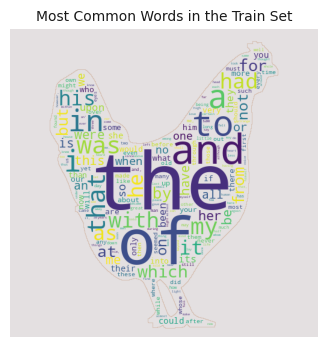

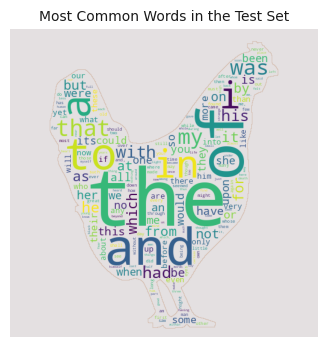

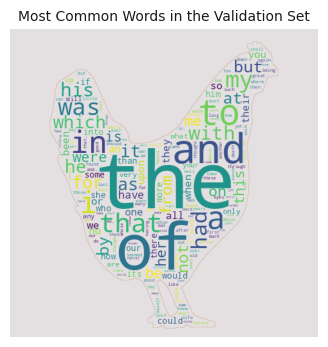

In [247]:
plot_wordcloud(
    train_counter, title="Most Common Words in the Train Set", mask="chicken", figsize=(4, 4),
    fontsize=10
)
plot_wordcloud(
    test_counter, title="Most Common Words in the Test Set", mask="chicken", figsize=(4, 4),
    fontsize=10
)

plot_wordcloud(
    valid_counter, title="Most Common Words in the Validation Set", mask="chicken", figsize=(4, 4),
    fontsize=10
)

### 🔖 Label Pipeline

Currently, our labels are in **text format**.  
To use them in machine learning models, we need to **convert these labels into numerical values**.  

The process is straightforward:  
1. Extract all **unique labels** from the dataset.  
2. Create a `labels_vocab` mapping that represents each label as an **integer**.  

This mapping allows the model to work with numerical labels while preserving the correspondence to the original authors.


In [248]:
labels_dict = {k: v for v, k in enumerate(train.author.unique())}
labels_dict

{'HPL': 0, 'EAP': 1, 'MWS': 2}

The `label_pipeline` function takes a **text label** as input and returns its corresponding **integer representation**.  
This allows us to consistently convert all author labels into numeric form for model training.


In [249]:
label_pipeline = lambda x: labels_dict[x]

### 📖 Vocabulary

Next, we will create a **Vocabulary class** and initialize it using the `counter` object.  

- We will set `min_freq = 2`, meaning any word that appears **less than 2 times** will be treated as an **unknown token**.  
- We will also specify **special tokens** (such as `<PAD>`, `<UNK>`, etc.) during the creation of the vocabulary object.  

This ensures that our vocabulary captures meaningful words while handling rare or unseen words appropriately.


In [250]:
class vocab:
    def __init__(self, counter, min_freq=1, specials=('[unk]', '[pad]', '[sos]', '[eos]')):
        self.freqs = counter
        self.itos = list(specials)
        self.stoi = {}
        for token, freq in counter.items():
            if freq >= min_freq and token not in self.itos:
                self.itos.append(token)

        self.stoi = defaultdict(lambda: self.itos.index('[unk]'))  # default to unk
        for idx, token in enumerate(self.itos):
            self.stoi[token] = idx

    def __len__(self):
        return len(self.itos)

    def __getitem__(self, token):
        return self.stoi[token]

    def get_stoi(self):
        return self.stoi
    def get_itos(self):
        return self.itos

vocabulary = vocab(train_counter, min_freq=2, specials=('[unk]', '[pad]', '[sos]', '[eos]'))

### 🔢 STOI - `String To Integer`

We will create a **dictionary mapping each word to a unique integer**, which will serve as our **actual vocabulary**.  

In the following code cell, we will initialize an object called `stoi` — a **word-to-index mapping**.  
This dictionary will be used both during **model training** and **inference** to convert words into numerical representations.


In [251]:
stoi = vocabulary.get_stoi()

### 📝 Text Pipeline

After tokenizing the text, we need a way to **convert words into numbers**, since machine learning models can only process numerical inputs.  

This is where the `text_pipeline` function comes in. The function:

1. Takes a **sentence** as input.  
2. Tokenizes the sentence into words.  
3. Converts each word into its corresponding **integer index** from the `stoi` vocabulary.  

**Note:** Any word not found in the vocabulary (`stoi`) will be mapped to the **unknown token** (`'[UNK]'`) with index `0`.


In [252]:
def text_pipeline(x: str):
  values = list()
  tokens = x.lower().split(" ")
  for token in tokens:
    try:
      v = stoi[token]
    except KeyError as e:
      v = stoi['[unk]']
    values.append(v)
  return values

### 📊 Data

The dataset was downloaded from the Kaggle repository linked above. In addition to the labeled texts and authors, we will use **pre-trained GloVe word embeddings** to convert words into dense semantic vectors. These embeddings help capture global word co-occurrence statistics, which can improve performance in text classification and stylometry tasks.

### 🔍 How GloVe Will Be Used

- We'll download pre-trained GloVe embeddings (e.g. 100-dim or 300-dim vectors).
- Use them to convert each word in our dataset into its embedding vector.
- Possibly average (or apply more advanced aggregation) the word vectors to represent each text snippet.
- Use these embedded text vectors for exploratory data analysis (comparing author style by vector similarity, clustering), before any classification modeling.





### 🌐 Pretrained Vectors

In the following code cell, we will download **pretrained word vectors** using `GloVe.6B.300d`.  

- These vectors were trained on approximately **6 billion words**.  
- Each word is represented as a **300-dimensional vector**, capturing semantic relationships between words.  
- Using these pretrained embeddings allows us to leverage prior knowledge of word semantics, which can improve model performance.


In [253]:
embedding_path = "/content/MyDrive/MyDrive/NLP Data/glove.6B/glove.6B.300d.txt"
EMBEDDING_DIM = 300
glove_vectors = dict()
with open(embedding_path, encoding="utf8") as glove:
  for line in glove:
    records = line.split();
    word = records[0]
    vectors = np.asarray(records[1: ], dtype=np.float32)
    glove_vectors[word] = vectors

### 🧩 Creating Embedding Matrix

Now that we have the GloVe vectors, we need to **customize them** to fit our use case.  

We will create an **embedding matrix** that aligns with our vocabulary.  
Essentially, this matrix provides a **word-to-vector mapping** for all the words in our vocabulary, allowing the model to convert each word index into its corresponding vector representation during training and inference.


In [355]:
VOCAB_SIZE = len(stoi)

EMBEDDING_MATRIX = torch.zeros((VOCAB_SIZE, EMBEDDING_DIM))
for word, index in stoi.items():
    vector = glove_vectors.get(word)
    try:
        if vector is not None:
            if isinstance(vector, torch.Tensor):
                EMBEDDING_MATRIX[index] = vector
            else:
                EMBEDDING_MATRIX[index] = torch.from_numpy(vector)
        else:
            EMBEDDING_MATRIX[index] = torch.zeros(EMBEDDING_DIM)
    except (IndexError, Exception):
        continue

In [356]:
assert VOCAB_SIZE == EMBEDDING_MATRIX.size(0), "They should be the same"

In the following code cell, we will **inspect the embedding matrix** by checking the vector representation for the word `"the"`.  
This helps verify that our embeddings have been correctly mapped to the vocabulary.


In [357]:
EMBEDDING_MATRIX[stoi['the']]

tensor([ 4.6560e-02,  2.1318e-01, -7.4364e-03, -4.5854e-01, -3.5639e-02,
         2.3643e-01, -2.8836e-01,  2.1521e-01, -1.3486e-01, -1.6413e+00,
        -2.6091e-01,  3.2434e-02,  5.6621e-02, -4.3296e-02, -2.1672e-02,
         2.2476e-01, -7.5129e-02, -6.7018e-02, -1.4247e-01,  3.8825e-02,
        -1.8951e-01,  2.9977e-01,  3.9305e-01,  1.7887e-01, -1.7343e-01,
        -2.1178e-01,  2.3617e-01, -6.3681e-02, -4.2318e-01, -1.1661e-01,
         9.3754e-02,  1.7296e-01, -3.3073e-01,  4.9112e-01, -6.8995e-01,
        -9.2462e-02,  2.4742e-01, -1.7991e-01,  9.7908e-02,  8.3118e-02,
         1.5299e-01, -2.7276e-01, -3.8934e-02,  5.4453e-01,  5.3737e-01,
         2.9105e-01, -7.3514e-03,  4.7880e-02, -4.0760e-01, -2.6759e-02,
         1.7919e-01,  1.0977e-02, -1.0963e-01, -2.6395e-01,  7.3990e-02,
         2.6236e-01, -1.5080e-01,  3.4623e-01,  2.5758e-01,  1.1971e-01,
        -3.7135e-02, -7.1593e-02,  4.3898e-01, -4.0764e-02,  1.6425e-02,
        -4.4640e-01,  1.7197e-01,  4.6246e-02,  5.8

### 📂 Creating Dataset for Training

In the following code cell, we will create a **dataset class** called `AuthorsDataset`.  
This class takes in the **text samples** and their corresponding **labels**, allowing us to efficiently load and preprocess data for model training.


In [358]:
class AuthorsDataset(torch.utils.data.Dataset):
  def __init__(self, labels, text):
    super(AuthorsDataset, self).__init__()
    self.text = text
    self.labels = labels

  def __getitem__(self, index):
    return self.labels[index], self.text[index]

  def __len__(self):
    return len(self.text)

### 🔄 `collate_fn`

We will create a **collate function** called `tokenize_batch`.  
This function takes a batch of data and performs **preprocessing on the text**, and it will be passed to the `DataLoader` to handle batch preparation efficiently.


### `tokenize_batch` Function Details

- The function takes in a **batch of samples** and converts the text features into their **integer representations**.  
- It **pads** or **truncates** sequences to a uniform length so that all inputs in a batch have the same size.  
- The function returns the processed **features**, ready for model input.


In [359]:
def tokenize_batch(batch, max_len=300, padding="pre"):
  assert padding=="pre" or padding=="post", "the padding can be either pre or post"
  labels_list, text_list = [], []
  for _label, _text in batch:
    labels_list.append(label_pipeline(_label))
    text_holder = torch.zeros(max_len, dtype=torch.int32)
    processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int32)
    pos = min(max_len, len(processed_text))
    if padding == "pre":
      text_holder[:pos] = processed_text[:pos]
    else:
      text_holder[-pos:] = processed_text[-pos:]
    text_list.append(text_holder.unsqueeze(dim=0))
  features = torch.cat(text_list, dim=0)
  return torch.FloatTensor(labels_list) if len(set(labels_list)) == 2 else torch.LongTensor(labels_list), features

### 📂 Datasets

In the following code cell, we will create the **datasets** for all three sets using the `AuthorsDataset` class.  
This organizes the data for **training, validation, and testing**, ensuring each set is properly prepared for model input.


In [360]:
train_dataset = AuthorsDataset(train_labels, train_texts)
test_dataset = AuthorsDataset(test_labels, test_texts)
valid_dataset = AuthorsDataset(valid_labels, valid_texts)

### 🔁 Iterators

In the following code cell, we will create **data loaders** using the `DataLoader` class from `torch.utils.data`.  
These loaders will handle **batching, shuffling, and preprocessing** of the datasets during training and evaluation.


In [361]:
BATCH_SIZE = 128
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=tokenize_batch)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=tokenize_batch)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=tokenize_batch)

### ✅ Checking a Single Batch

In this step, we will inspect a **single batch of data** from the DataLoader.  
This allows us to verify that the **features and labels** are correctly processed and ready for model training.


In [362]:
lbl, txt = next(iter(train_loader))

Checking a single batch of labels.

In [363]:
lbl

tensor([0, 1, 2, 0, 2, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 2,
        2, 1, 0, 0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 0, 1, 2, 0, 2, 1, 1, 2, 1, 0, 2,
        2, 2, 2, 2, 0, 0, 0, 1, 2, 0, 0, 2, 1, 2, 1, 2, 0, 2, 1, 0, 1, 2, 1, 1,
        1, 0, 2, 2, 2, 0, 0, 2, 0, 0, 1, 2, 1, 0, 1, 0, 1, 0, 0, 2, 2, 0, 0, 1,
        0, 0, 2, 0, 0, 1, 2, 0, 1, 2, 1, 2, 2, 0, 1, 2, 0, 1, 2, 2, 0, 1, 0, 1,
        1, 1, 1, 1, 2, 2, 2, 2])

The first sentence in the batch.

In [364]:
txt[0]

tensor([  115,   129,  2337,    82, 11408,    44,   199, 10964, 11542,   141,
          327,   107, 12332,     0,   165,    11,  5559,  1465,  8985,  7861,
           32,  9458,    15,    11,  1497,  5248,   107,   539,  3332,  5161,
           30,  4439,    28,    30,  4669,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0, 

### 🧠 AuthorsBiLSTM

In the following code cell, we will **build a model using LSTM layers** for classifying text by author.  

We use a **BiLSTM (Bidirectional LSTM)** model because it is well-suited for efficiently processing **sequential data**, as supported by previous studies (Ngwenya & Garidzira, 2025; Vambe & Garidzira, 2024; Siami-Namini et al., 2019).

**References:**

1. Ngwenya, S. & Garidzira, T.C. (2025). *Enhanced Fake News Detection with Domain-Specific Word Embeddings: A TorchText-Based Method for News Semantics Representation.* The Indonesian Journal of Computer Science, 14(4).  
2. Vambe, W.T. & Garidzira, T.C. (2024, November). *A Comparative Analysis of Convolutional Neural Networks, Bi-Directional Gated Recurrent Units, and Bi-Directional Long Short-Term Memory for Sequential Data Processing Using Human Emotions Dataset.* In 2024 4th International Multidisciplinary Information Technology and Engineering Conference (IMITEC) (pp. 01-08). IEEE.  
3. Siami-Namini, S., Tavakoli, N., & Namin, A.S. (2019, December). *The Performance of LSTM and BiLSTM in Forecasting Time Series.* In 2019 IEEE International Conference on Big Data (Big Data) (pp. 3285-3292). IEEE.


In [365]:
class AuthorsBiLSTM(nn.Module):
    def __init__(
        self,
        vocab_size,
        embedding_size,
        hidden_size,
        output_size,
        num_layers=2,
        bidirectional=True,
        dropout=0.5,
        pad_index=0,
        embedding_matrix=None
    ):
        super(AuthorsBiLSTM, self).__init__()
        self.embedding = nn.Embedding(
            num_embeddings=vocab_size,
            embedding_dim=embedding_size,
            padding_idx=pad_index
        )

        if embedding_matrix is not None:
            self.embedding.weight.data.copy_(embedding_matrix)
        self.lstm = nn.LSTM(
            input_size=embedding_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            bidirectional=bidirectional,
            dropout=dropout if num_layers > 1 else 0,
            batch_first=True
        )
        self.layer_norm = nn.LayerNorm(hidden_size * 2 if bidirectional else hidden_size)
        self.out = nn.Linear(hidden_size * 2 if bidirectional else hidden_size, output_size)
        self.dropout = nn.Dropout(dropout)
        self.bidirectional = bidirectional

    def forward(self, text, text_lengths):
        embedded = self.embedding(text)  # (batch_size, seq_len, embedding_size)
        packed_embedded = nn.utils.rnn.pack_padded_sequence(
            embedded, text_lengths.cpu(), batch_first=True, enforce_sorted=False
        )

        packed_output, (hidden, cell) = self.lstm(packed_embedded)
        if self.bidirectional:
            hidden = torch.cat([hidden[-2], hidden[-1]], dim=1)
        else:
            hidden = hidden[-1]

        hidden = self.layer_norm(hidden)
        hidden = self.dropout(hidden)
        return self.out(hidden)

Next, we will create an **instance of the `AuthorsBiLSTM` model**.  
This initializes the network with the specified architecture, ready for training on our dataset.


In [366]:
INPUT_DIM = VOCAB_SIZE
EMBEDDING_DIM = 300
HIDDEN_DIM = 128
OUTPUT_DIM = 1 if len(labels_dict) == 2 else len(labels_dict)
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.6321
PAD_IDX = stoi['[pad]']
author_bilstm = AuthorsBiLSTM(
              INPUT_DIM,
              EMBEDDING_DIM,
              HIDDEN_DIM,
              OUTPUT_DIM,
              N_LAYERS,
              BIDIRECTIONAL,
              DROPOUT,
              PAD_IDX
).to(device)
author_bilstm

AuthorsBiLSTM(
  (embedding): Embedding(33626, 300, padding_idx=1)
  (lstm): LSTM(300, 128, num_layers=2, batch_first=True, dropout=0.6321, bidirectional=True)
  (layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (out): Linear(in_features=256, out_features=3, bias=True)
  (dropout): Dropout(p=0.6321, inplace=False)
)

### ⚙️ Model Parameters

In the following code cell, we will **count the number of parameters** in our `AuthorsBiLSTM` model.  
This helps us understand the **model's complexity** and the number of learnable weights.


In [367]:
def count_trainable_params(model):
  return f"{sum(p.numel() for p in model.parameters()):,}", f"{sum(p.numel() for p in model.parameters() if p.requires_grad):,}"

columns = ["MODEL", "TOTAL PARAMS", "TRAINABLE PARAMS"]
data = [
    ["BiLSTM", *count_trainable_params(author_bilstm)],
]
tabulate_data(columns, data, title="Models Parameters")

Models Parameters
+--------+--------------+------------------+
| MODEL  | TOTAL PARAMS | TRAINABLE PARAMS |
+--------+--------------+------------------+
| BiLSTM |   10,924,667 |       10,924,667 |
+--------+--------------+------------------+


### 🌐 Loading Embedding Vectors

In the following code cells, we will **load the pretrained custom vectors** into the embedding layer of our model.  
We will assign the vectors that correspond to our vocabulary using:

```python
model.embedding[0].weight.data.copy_(EMBEDDING_MATRIX)
```

> This ensures that the model starts with meaningful word representations based on GloVe embeddings.

In [368]:
assert EMBEDDING_MATRIX.size(0) == VOCAB_SIZE, "This must match!"

In [369]:
author_bilstm.embedding.weight.data.copy_(EMBEDDING_MATRIX)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0')

### ⚡ Optimizer and Criterion

We will use the **Adam optimizer** for training the model.  

For the loss function, we will use **`CrossEntropyLoss()`**, as this is a **multi-class classification** problem where each text sample belongs to one of several authors.


In [372]:
optimizer = torch.optim.Adam(
    author_bilstm.parameters(),
    lr=1e-3,
    weight_decay=1e-5,
    betas=(0.9, 0.999),
    eps=1e-8
)

criterion = nn.CrossEntropyLoss().to(device)

In the following code cell, we will create the **`categorical_accuracy` function**.  
This function calculates the **categorical accuracy** by comparing the predicted labels with the true labels, providing a measure of model performance for multi-class classification.


In [373]:
def categorical_accuracy(preds, y):
  top_pred = preds.argmax(1, keepdim = True)
  correct = top_pred.eq(y.view_as(top_pred)).sum()
  acc = correct.float() / y.shape[0]
  return acc

### 🏋️ Training and Evaluation Functions

In the following code cell, we will define the **`train_fn`** and **`evaluate_fn`** functions:  

- **`train_fn`**: Handles the forward pass, loss computation, and backpropagation for model training.  
- **`evaluate_fn`**: Computes the loss and accuracy on validation or test data without updating the model weights.


In [374]:
def train_fn(model, iterator, optimizer, criterion):
  epoch_loss,epoch_acc = 0, 0
  model.train()
  for batch in iterator:
    y, X = batch
    X = X.to(device)
    y = y.to(device).long()
    lengths = torch.tensor([len(i) for i in X])
    optimizer.zero_grad()
    predictions = model(X, lengths).squeeze(1)
    loss = criterion(predictions, y)
    acc = categorical_accuracy(predictions, y)
    loss.backward()
    optimizer.step()
    epoch_loss += loss.item()
    epoch_acc += acc.item()
  return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate_fn(model, iterator, criterion):
  epoch_loss,epoch_acc = 0, 0
  model.eval()
  with torch.no_grad():
    for batch in iterator:
      y, X = batch
      X = X.to(device)
      y = y.to(device).long()
      lengths = torch.tensor([len(i) for i in X])
      predictions = model(X, lengths).squeeze(1)
      loss = criterion(predictions, y)
      acc = categorical_accuracy(predictions, y)
      epoch_loss += loss.item()
      epoch_acc += acc.item()
  return epoch_loss / len(iterator), epoch_acc / len(iterator)

### 🔄 Training Loop

During model training, we will **train the model** while continuously tracking its performance.  

The following `History` class serves as a **data structure to store the training history**, including metrics such as loss and accuracy for each epoch.


In [375]:
class History:
  def __init__(self):
    self.train_losses = list()
    self.train_acc = list()
    self.epoch_train_time = list()
    self.val_losses = list()
    self.val_acc = list()

  def add(self, train_loss:float, train_acc:float, val_loss:float, val_acc:float, elt:float):
    self.train_losses.append(train_loss)
    self.val_losses.append(val_loss)
    self.train_acc.append(train_acc)
    self.val_acc.append(val_acc)
    self.epoch_train_time.append(elt)

In the following code cell, we will define the **`run_train_loop` function**.  
This function orchestrates the **entire training process**, including running the training and evaluation steps for multiple epochs and updating the training history.


In [376]:
def run_train_loop(model, model_name, train_loader, val_loader,  epochs=6, optimizer=None, criterion=None):
  best_valid_loss = float('inf')
  last_saved_epoch = 1
  history = History()
  training_start = time.time()
  for epoch in range(epochs):
    start = time.time()
    train_loss, train_acc = train_fn(model, train_loader, optimizer, criterion)
    valid_loss, valid_acc = evaluate_fn(model, val_loader, criterion)
    title = f"EPOCH: {epoch+1:02}/{epochs:02} {'saving best model...' if valid_loss < best_valid_loss else 'not saving...'}"
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), model_name)
        last_saved_epoch = epoch+1
    end = time.time()
    history.add(train_loss, train_acc, valid_loss, valid_acc, end-start)
    data = [
        ["Training", f'{train_loss:.3f}', f'{train_acc:.3f}', f"{hms_string(end - start)}" ],
        ["Validation", f'{valid_loss:.3f}', f'{valid_acc:.3f}', "" ],
    ]
    columns = ["CATEGORY", "LOSS", "ACCURACY", "ETA"]
    tabulate_data(columns, data, title)

  training_end = time.time()
  return history, training_end - training_start, last_saved_epoch

In [377]:
EPOCHS = 10
history, elt, last_saved_epoch = run_train_loop(
    author_bilstm, 'lstm.pt', train_loader, test_loader, EPOCHS,
    optimizer=optimizer, criterion=criterion
)


EPOCH: 01/10 saving best model...
+------------+-------+----------+------------+
| CATEGORY   |  LOSS | ACCURACY |        ETA |
+------------+-------+----------+------------+
| Training   | 1.117 |    0.414 | 0:00:05.25 |
| Validation | 1.005 |    0.496 |            |
+------------+-------+----------+------------+
EPOCH: 02/10 saving best model...
+------------+-------+----------+------------+
| CATEGORY   |  LOSS | ACCURACY |        ETA |
+------------+-------+----------+------------+
| Training   | 0.851 |    0.627 | 0:00:05.31 |
| Validation | 0.705 |    0.714 |            |
+------------+-------+----------+------------+
EPOCH: 03/10 not saving...
+------------+-------+----------+------------+
| CATEGORY   |  LOSS | ACCURACY |        ETA |
+------------+-------+----------+------------+
| Training   | 0.515 |    0.810 | 0:00:05.26 |
| Validation | 0.744 |    0.704 |            |
+------------+-------+----------+------------+
EPOCH: 04/10 saving best model...
+------------+-------+---

Next, we will **save the files** that will be used later for **model inference**.  
This ensures that the trained model and necessary artifacts (e.g., vocabulary, embeddings) are preserved for making predictions on new data.


In [397]:
with open("vocab.json", "w", encoding="utf-8") as f:
    json.dump(stoi, f, indent=2, ensure_ascii=False)

with open("labels_dict.json", 'w',  encoding="utf-8") as f:
    json.dump(labels_dict, f, indent=2, ensure_ascii=False)
print("Done!")

Done!


Next, we will **download the static file**.  
This file contains the necessary resources or model artifacts required for inference or further analysis.


In [379]:
from google.colab import files
files.download('lstm.pt')
files.download('vocab.json')
files.download('labels_dict.json')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Next, we will **check the last saved epoch** and the **total training time** for the `LSTM` model.  
This helps us understand the training duration and confirm the point at which the model was last saved.


In [380]:
rows = [
      ["TOTAL EPOCHS", f'{EPOCHS}'],
      ["LAST SAVED EPOCH", f'{last_saved_epoch}'],
      ["TOTAL TRAINING TIME", f'{hms_string(elt)}']
]
tabulate_data(['', 'value'], rows, "LSTM MODEL TOTAL TRAINING TIME AND LAST SAVED EPOCH")

LSTM MODEL TOTAL TRAINING TIME AND LAST SAVED EPOCH
+---------------------+------------+
|                     |      value |
+---------------------+------------+
| TOTAL EPOCHS        |         10 |
| LAST SAVED EPOCH    |          5 |
| TOTAL TRAINING TIME | 0:00:53.08 |
+---------------------+------------+


### 📈 Training History

In the following code cells, we will **visualize the training progress** observed during model training.  

The first plot will show the **time taken to complete each epoch**, providing insights into training efficiency and computational performance.


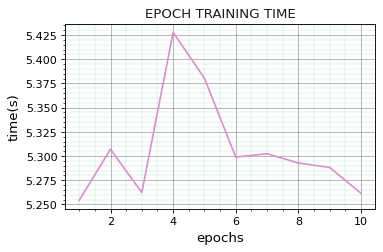

In [381]:
epochs = np.arange(1, EPOCHS + 1)
plt.figure(figsize=(5, 3), dpi=80)
plt.plot(epochs, history.epoch_train_time, color=PALETTES.gradient[9], label='lstm')
plt.title("EPOCH TRAINING TIME", color="k", fontsize=12)
plt.xlabel("epochs", fontsize=12)
plt.ylabel("time(s)", fontsize=12)

plt.minorticks_on()
plt.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
plt.grid(which='minor', color='#7ED4AD', linestyle='--', linewidth=0.3)

plt.show()

Next, we will **visualize the training and validation loss** using a line graph.  
This plot shows how the loss evolved during training, helping us assess model convergence and detect potential overfitting.


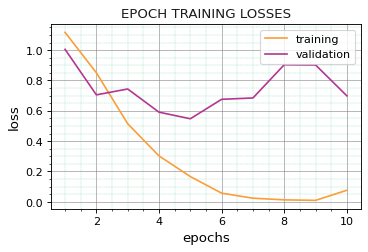

In [382]:
plt.figure(figsize=(5, 3), dpi=80)
plt.plot(epochs, history.train_losses, color=PALETTES.gradient[14], label='training')
plt.plot(epochs, history.val_losses, color=PALETTES.gradient[11], label='validation')
plt.title("EPOCH TRAINING LOSSES", color="k", fontsize=12)
plt.xlabel("epochs", fontsize=12)
plt.ylabel("loss", fontsize=12)
plt.legend(fontsize=10)
plt.minorticks_on()
plt.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
plt.grid(which='minor', color='#7ED4AD', linestyle='--', linewidth=0.3)

plt.show()


Next, we will **visualize the training and validation accuracies** using a line graph.  
This plot shows how the model's accuracy evolved during training, allowing us to evaluate performance and monitor potential overfitting.


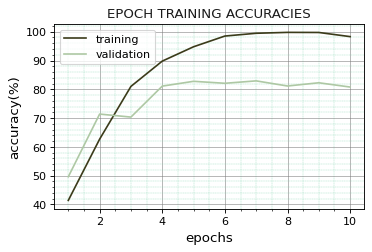

In [383]:
plt.figure(figsize=(5, 3), dpi=80)
plt.plot(epochs, [acc * 100 for acc in history.train_acc], color=PALETTES.gradient[20], label='training')
plt.plot(epochs, [acc * 100 for acc in history.val_acc], color=PALETTES.gradient[22], label='validation')

plt.title("EPOCH TRAINING ACCURACIES", color="k", fontsize=12)
plt.xlabel("epochs", fontsize=12)
plt.ylabel("accuracy(%)", fontsize=12)
plt.legend(fontsize=10)

plt.minorticks_on()
plt.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
plt.grid(which='minor', color='#7ED4AD', linestyle='--', linewidth=0.3)

plt.show()

### 🏆 Best Model Evaluations

In the following code cell, we will **evaluate the best saved model** for each architecture.  
This allows us to assess the performance of the top-performing model on the validation or test data.


In [384]:
author_bilstm.load_state_dict(torch.load('lstm.pt'))
bilstm_test_loss, bistm_test_acc = evaluate_fn(author_bilstm, test_loader, criterion)
print(f'Test Loss: {bilstm_test_loss:.3f} | Test Acc: {bistm_test_acc*100:.2f}%')

Test Loss: 0.548 | Test Acc: 82.78%


Next, we will **make predictions on the test dataset** using our trained model.  
This step allows us to see how well the model generalizes to unseen data.


In [385]:
def get_predictions(model, iterator, device):
  model.eval()
  labels = []
  predictions = []
  with torch.no_grad():
    for (y, X) in iterator:
      X = X.to(device)
      lengths = torch.tensor([len(i) for i in X])
      y_pred = model(X, lengths).squeeze(1)
      y_prob = F.softmax(y_pred).cpu().argmax(dim=1)
      labels.append(y.cpu())
      predictions.append(y_prob.cpu())
  labels = torch.cat(labels, dim = 0).numpy()
  predictions = torch.cat(predictions, dim = 0).numpy()
  return labels, predictions
y_true, y_preds = get_predictions(author_bilstm, test_loader, device)

### 🧮 Confusion Matrix

In the following code cell, we will **plot the confusion matrix** for our model.  
This visualization helps us understand how well the model predicts each author and where misclassifications occur.


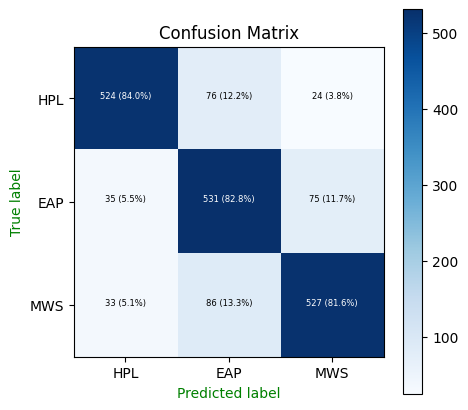

In [386]:
plt.style.use('default')
plot_complicated_confusion_matrix(y_true, y_preds,
  labels_dict.keys(), fontsize=6, figsize=(5, 5)
)

### 📋 Classification Report

Next, we will **generate and display the classification report** for our model using the test dataset.  
This report provides metrics such as **precision, recall, F1-score, and support** for each author class.


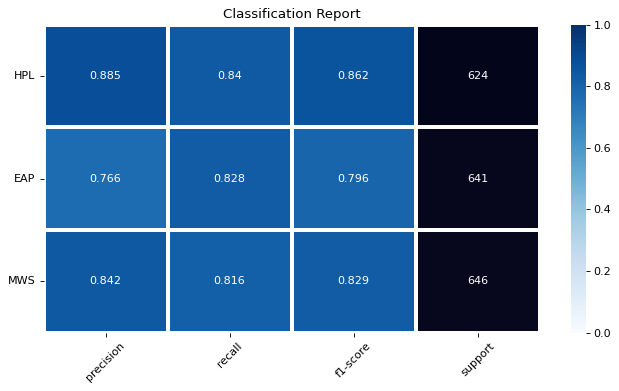

In [387]:
fig, ax = plot_classification_report(
    y_true, y_preds,
    title='Classification Report',
    figsize=(10, 5), dpi=80,
    target_names = labels_dict.keys()
)

### 🤖 Model Inference

In this section, we will **test our model's ability to make predictions** based on user input.  

In the following code cell, we will use the **best model** to generate predictions.  
We will define a function called `inference_preprocess_text`, which **preprocesses the input text** to prepare it for inference.


In [388]:
def inference_preprocess_text(text, max_len=300, padding="pre"):
  assert padding=="pre" or padding=="post", "the padding can be either pre or post"
  text_holder = torch.zeros(max_len, dtype=torch.int32) # fixed size tensor of max_len with  = 0
  processed_text = torch.tensor(text_pipeline(text), dtype=torch.int32)
  pos = min(max_len, len(processed_text))
  if padding == "pre":
    text_holder[:pos] = processed_text[:pos]
  else:
    text_holder[-pos:] = processed_text[-pos:]
  text_list= text_holder.unsqueeze(dim=0)
  return text_list

In [399]:
classes = list(labels_dict.keys())
authors =   [ "HP Lovecraft",  "Edgar Allan Poe", "Mary Shelley" ]
def predict_author(model, sentence, device):
    model.eval()
    with torch.no_grad():
      tensor = inference_preprocess_text(sentence).to(device)
      length = torch.tensor([len(t) for t in tensor])
      probs = F.softmax(model(tensor, length).squeeze(0))
      top = {
          'label': int(probs.argmax().item()),
          'probability': float(probs.max().item()),
          "class": classes[probs.argmax().item()],
          "author": authors[probs.argmax().item()]
      }
      predictions = [
          {
              'label': i,
              'probability': float(prob),
              "class": classes[i],
              "author": authors[i]
          } for i, prob in enumerate(probs)
      ]
      return {'top': top, 'predictions': predictions}

### 📝 Prediction Example

In the following code cell, we will **predict a sample input**.  
This example demonstrates how the model can classify a simple text, such as an order cancellation request, based on learned patterns.


In [400]:
test.head()

,id,text,author
0,id07955,"What, indeed, was my passion for the young gir...",EAP
1,id00315,"I shall say nothing more upon this point; and,...",EAP
2,id21451,Some of the neighbouring families who had hear...,HPL
3,id04917,It was in one of the most open and least frequ...,HPL
4,id26199,"After some delay, a cart arrived at the wharf,...",EAP


In [401]:
test.iloc[4].text

'After some delay, a cart arrived at the wharf, with an oblong pine box, which was every thing that seemed to be expected.'

### `Author: HPL`

In [402]:
predict_author(author_bilstm,
               'dee Hi Hi Randy" A swaying lantern came around the black bend, and old Benijah pounced on the silent and bewildered form of the pilgrim.',
               device=device)

{'top': {'label': 0,
  'probability': 0.9894408583641052,
  'class': 'HPL',
  'author': 'HP Lovecraft'},
 'predictions': [{'label': 0,
   'probability': 0.9894408583641052,
   'class': 'HPL',
   'author': 'HP Lovecraft'},
  {'label': 1,
   'probability': 0.009701662696897984,
   'class': 'EAP',
   'author': 'Edgar Allan Poe'},
  {'label': 2,
   'probability': 0.0008575011161155999,
   'class': 'MWS',
   'author': 'Mary Shelley'}]}

### `Author: MWS`

In [403]:
predict_author(
    author_bilstm, 'How mutable are our feelings, and how strange is that clinging love we have of life even in the excess of misery I constructed another sail with a part of my dress and eagerly steered my course towards the land.',
    device=device
)

{'top': {'label': 2,
  'probability': 0.9945909976959229,
  'class': 'MWS',
  'author': 'Mary Shelley'},
 'predictions': [{'label': 0,
   'probability': 0.0010808007791638374,
   'class': 'HPL',
   'author': 'HP Lovecraft'},
  {'label': 1,
   'probability': 0.004328244831413031,
   'class': 'EAP',
   'author': 'Edgar Allan Poe'},
  {'label': 2,
   'probability': 0.9945909976959229,
   'class': 'MWS',
   'author': 'Mary Shelley'}]}

### `Author: EAP`

In [404]:
predict_author(
    author_bilstm, 'These peculiarities are, no doubt, mere mannerisms of M. Maelzel, or, if he is aware of them at all, he puts them in practice with a view of exciting in the spectators a false idea of the pure mechanism in the Automaton.',
    device=device
)

{'top': {'label': 1,
  'probability': 0.9966593980789185,
  'class': 'EAP',
  'author': 'Edgar Allan Poe'},
 'predictions': [{'label': 0,
   'probability': 0.0019294441444799304,
   'class': 'HPL',
   'author': 'HP Lovecraft'},
  {'label': 1,
   'probability': 0.9966593980789185,
   'class': 'EAP',
   'author': 'Edgar Allan Poe'},
  {'label': 2,
   'probability': 0.0014111659256741405,
   'class': 'MWS',
   'author': 'Mary Shelley'}]}